# XGBoost Model with Explainer & Outlier Detector
This notebook walks through how to create an XGBoost model trained on the Iris dataset. These are then deployed to Seldon Deploy v1.0 via the API. The workflow for each of the components is as follows:
1. Train algorithm
2. Push trained artefact to Google Storage bucket
3. Create deployment on Seldon Deploy via API


**Predictor**
- Algorithm: XGBoost
- Dataset: Iris (Continuous tabular)

**Explainer**
- Algorithm: AnchorTabular

**Outlier Detector (OD)**
- Algorithm: Mahalanobis Distance Detector

**Drift Detector (DD)**
- Algorithm: Kolmogorov-Smirnov Detector

### Import relevant packages

In [11]:
from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, OutlierDetectorApi, DriftDetectorApi
from seldon_deploy_sdk.auth import OIDCAuthenticator

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

import numpy as np
import pandas as pd

import xgboost as xgb

from alibi.explainers import AnchorTabular

from alibi_detect.od import Mahalanobis
from alibi_detect.cd import KSDrift
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.mapping import ord2ohe
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

import dill
import os

import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data

In [12]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)

X = dataset.data
y = dataset.target

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model training

In [4]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [5]:
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'num_class': 3} 

num_round = 20

In [6]:
bst = xgb.train(param, dtrain, num_round)

In [7]:
preds = np.asarray([np.argmax(line) for line in bst.predict(dtest)])
print(precision_score(y_test, preds, average="macro"))
print(recall_score(y_test, preds, average="macro"))
print(accuracy_score(y_test, preds))

0.9722222222222222
0.9629629629629629
0.9666666666666667


Perfect, now that our model is nicely overfitted we can save it. 

The XGBoost pre-packaged server expects our model to be called `model.bst` when it is uploaded to our storage bucket.

In [8]:
bst.save_model('model.bst')

Uploading the model to a Google Storage bucket (to run this command you need to have the `gsutil` CLI tool installed). 

The thing to note here is that the pre-packaged XGBoost server expects to look inside of a folder for the `model.bst` artefact. Therefore, we create a `/xgboost` dir to hold our model artefact. 

TODO: Adapt this to AWS so it is more relevant. 

In [9]:
!gsutil cp model.bst gs://tom-seldon-examples/xgboost/model.bst

Copying file://model.bst [Content-Type=application/octet-stream]...
/ [1 files][  2.7 KiB/  2.7 KiB]                                                
Operation completed over 1 objects/2.7 KiB.                                      


### Model Deployment

Deploying the model to a Seldon Deploy trial instance using the `seldon-deploy-sdk`. 

First, setting up the configuration and authentication required to access the cluster. 

In [31]:
SD_IP = "138.68.117.161"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"

def auth():
    auth = OIDCAuthenticator(config)
    config.access_token = auth.authenticate("admin@seldon.io", "12341234")
    api_client = ApiClient(config)
    return api_client

In [32]:
DEPLOYMENT_NAME = "xgboost-sample"
NAMESPACE = "dev"
PREPACKAGED_SERVER = "XGBOOST_SERVER"
MODEL_LOCATION = "gs://tom-seldon-examples/xgboost"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

In [33]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

OAuthError: unauthorized_client: INVALID_CREDENTIALS: Invalid client credentials

### Adding a Model Explainer

Need to define a prediction function which our explainer can make use of. 

In [13]:
predict_fn = lambda x: bst.predict(xgb.DMatrix(x))

Now, define and fit the AnchorTabular explainer. 

In [14]:
explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_train, disc_perc=(25, 50, 75))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': None}}
)

Predicting the first instance within the test set, and consequently generating an explanation for that prediction.

In [15]:
idx = 0
print('Prediction: ', class_names[explainer.predictor(X_test[idx].reshape(1, -1))[0]])

explanation = explainer.explain(X_test[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  versicolor


Could not find an result satisfying the 0.95 precision constraint. Now returning the best non-eligible result.


Anchor: 1.50 < petal length (cm) <= 5.10 AND 0.30 < petal width (cm) <= 1.30 AND sepal length (cm) > 5.10 AND sepal width (cm) <= 3.40
Precision: 0.78
Coverage: 0.53


Save the explainer. Your explainer must be saved as `explainer.dill` as once again Seldon Deploy will look for this artefact within a top level directory. 

NOTE: Dill is used to serialise the object instead of pickle as it offers a greater flexibilty in the object types which can be serialised. 

In [16]:
dill.dump(explainer, open( "explainer.dill", "wb"))

Uploading the model to a Google Storage bucket. 

In [109]:
!gsutil cp explainer.dill gs://tom-seldon-examples/xgboost/explainer.dill

Copying file://explainer.dill [Content-Type=application/octet-stream]...
| [1 files][104.6 MiB/104.6 MiB]    1.8 MiB/s                                   
Operation completed over 1 objects/104.6 MiB.                                    


Defining our explainer configuration.

In [17]:
EXPLAINER_TYPE = "AnchorTabular"
EXPLAINER_URI = "gs://tom-seldon-examples/xgboost"

explainer_spec = {
                    "type": EXPLAINER_TYPE,
                    "modelUri": EXPLAINER_URI,
                    "containerSpec": {
                        "name": "",
                        "resources": {}
                    }
                }

Inserting our explainer configuration into the original `mldeployment`

In [18]:
mldeployment['spec']['predictors'][0]['explainer'] = explainer_spec
mldeployment

{'kind': 'SeldonDeployment',
 'metadata': {'name': 'xgboost-sample',
  'namespace': 'dev',
  'labels': {'fluentd': 'true'}},
 'apiVersion': 'machinelearning.seldon.io/v1alpha2',
 'spec': {'name': 'xgboost-sample',
  'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
  'protocol': 'seldon',
  'transport': 'rest',
  'predictors': [{'componentSpecs': [{'spec': {'containers': [{'name': 'xgboost-sample-container',
         'resources': {'requests': {'cpu': '1', 'memory': '1Gi'},
          'limits': {'cpu': '1', 'memory': '1Gi'}}}]}}],
    'name': 'default',
    'replicas': 1,
    'traffic': 100,
    'graph': {'implementation': 'XGBOOST_SERVER',
     'modelUri': 'gs://tom-seldon-examples/xgboost',
     'name': 'xgboost-sample-container',
     'endpoint': {'type': 'REST'},
     'parameters': [],
     'children': [],
     'logger': {'mode': 'all'}},
    'explainer': {'type': 'AnchorTabular',
     'modelUri': 'gs://tom-seldon-examples/xgboost',
     'containerSpec': {'n

Finally, creating our new deployment with the explainer added. 

In [24]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

OAuthError: unauthorized_client: INVALID_CREDENTIALS: Invalid client credentials

### Generating an Outlier Detector

In [20]:
threshold = None
n_components = 2
std_clip = 3
start_clip = 20

od = Mahalanobis(threshold,
                 n_components=n_components,
                 std_clip=std_clip,
                 start_clip=start_clip)

No threshold level set. Need to infer threshold using `infer_threshold`.


In [25]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)

np.random.seed(0)
perc_outlier = 5

threshold_batch = create_outlier_batch(X_train, y_train, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


In [26]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))
threshold = od.threshold

New threshold: 8.106895432873086


In [27]:
np.random.seed(1)
outlier_batch = create_outlier_batch(X_train, y_train, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 4) (1000,)
10.0% outliers


In [28]:
od_preds = od.predict(X_outlier, return_instance_score=True)

F1 score: 0.9743589743589743


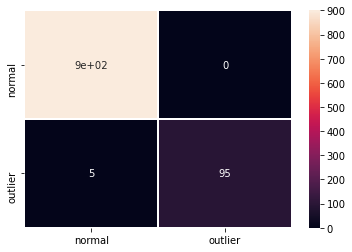

In [29]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

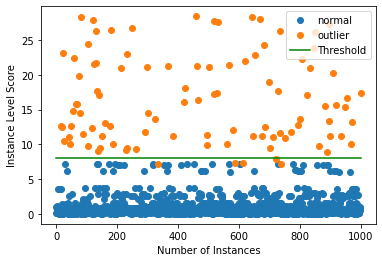

In [30]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

In [31]:
save_detector(od, "outlier_detector")

In [32]:
# Recursive copy this time as the OD is saved as a directory containing all the relevant binaries and parameters. 
!gsutil cp -r outlier_detector gs://tom-seldon-examples/xgboost

Copying file://outlier_detector/Mahalanobis.pickle [Content-Type=application/octet-stream]...
Copying file://outlier_detector/meta.pickle [Content-Type=application/octet-stream]...
/ [2 files][  820.0 B/  820.0 B]                                                
Operation completed over 2 objects/820.0 B.                                      


In [39]:
OD_URI = 'gs://tom-seldon-examples/xgboost/outlier_detector/'
OD_NAME = 'mahalobanis-od'

od_config = {'deployment': DEPLOYMENT_NAME,
             'deployment_namespace': None,
             'namespace': 'seldon-logs',
             'params': {'drift_batch_size': None,
                        'env_secret_ref': None,
                        'event_source': f'io.seldon.serving.dev-seldondeployment-{DEPLOYMENT_NAME}-outlier',
                        'event_type': 'io.seldon.serving.inference.outlier',
                        'http_port': '8080',
                        'model_name': OD_NAME,
                        'protocol': 'seldon.http',
                        'reply_url': 'http://seldon-request-logger.seldon-logs',
                        'storage_uri': OD_URI,
                        'user_permission': None},
             'prom_scraping': None,
             'url': None}

In [40]:
od_api = OutlierDetectorApi(auth())
od_api.create_outlier_detector_seldon_deployment(name=DEPLOYMENT_NAME,
                                                 namespace=NAMESPACE,
                                                 outlier_detector=od_config)

{'deployment': 'xgboost-sample',
 'deployment_namespace': None,
 'namespace': 'seldon-logs',
 'params': {'drift_batch_size': None,
            'env_secret_ref': None,
            'event_source': 'io.seldon.serving.dev-seldondeployment-xgboost-sample-outlier',
            'event_type': 'io.seldon.serving.inference.outlier',
            'http_port': '8080',
            'model_name': 'mahalobanis-od',
            'protocol': 'seldon.http',
            'reply_url': 'http://seldon-request-logger.seldon-logs',
            'storage_uri': 'gs://tom-seldon-examples/xgboost/outlier_detector/',
            'user_permission': None},
 'prom_scraping': None,
 'url': None}

### Drift Detection
Next, we will train and deploy a drift detector to the cluster.

In [6]:
from alibi_detect.cd import KSDrift

dd = KSDrift(
    p_val=0.05,
    X_ref=X_train,
    preprocess_X_ref=False,
    preprocess_kwargs=None,
    alternative='two-sided',
    correction='bonferroni'
)

In [7]:
preds_drift = dd.predict(X_test, return_p_val=True, return_distance=True)
preds_drift

{'data': {'is_drift': 0,
  'distance': array([0.11666667, 0.06666667, 0.11666667, 0.13333334], dtype=float32),
  'p_val': array([0.8624313, 0.9996419, 0.8624313, 0.7382182], dtype=float32),
  'threshold': 0.0125},
 'meta': {'name': 'KSDrift', 'detector_type': 'offline', 'data_type': None}}

In [8]:
## TODO: Add code to perturb examples so that drift is detected.

In [68]:
save_detector(dd, "drift_detector")

Directory drift_detector does not exist and is now created.


In [69]:
# Recursive copy this time as the OD is saved as a directory containing all the relevant binaries and parameters. 
!gsutil cp -r drift_detector gs://tom-seldon-examples/xgboost

Copying file://drift_detector/meta.pickle [Content-Type=application/octet-stream]...
Copying file://drift_detector/KSDrift.pickle [Content-Type=application/octet-stream]...
/ [2 files][  4.2 KiB/  4.2 KiB]                                                
Operation completed over 2 objects/4.2 KiB.                                      


In [16]:
DD_URI = 'gs://tom-seldon-examples/xgboost/drift_detector/'
DD_NAME = 'KSDrift-Detector'

dd_config = {'deployment': DEPLOYMENT_NAME,
             'deployment_namespace': None,
             'namespace': 'seldon-logs',
             'params': {'drift_batch_size': '10',
                        'env_secret_ref': None,
                        'event_source': f'io.seldon.serving.dev-seldondeployment-{DEPLOYMENT_NAME}-drift',
                        'event_type': 'io.seldon.serving.inference.drift',
                        'http_port': '8080',
                        'model_name': DD_NAME,
                        'protocol': 'seldon.http',
                        'reply_url': 'http://seldon-request-logger.seldon-logs',
                        'storage_uri': DD_URI,
                        'user_permission': None},
             'prom_scraping': None,
             'url': None}

In [17]:
dd_api = DriftDetectorApi(auth())
dd_api.create_drift_detector_seldon_deployment(name=DEPLOYMENT_NAME,
                                               namespace=NAMESPACE,
                                               drift_detector=dd_config)

{'deployment': 'xgboost-sample',
 'deployment_namespace': None,
 'namespace': 'seldon-logs',
 'params': {'drift_batch_size': '10',
            'env_secret_ref': None,
            'event_source': 'io.seldon.serving.dev-seldondeployment-xgboost-sample-drift',
            'event_type': 'io.seldon.serving.inference.drift',
            'http_port': '8080',
            'model_name': 'KSDrift-Detector',
            'protocol': 'seldon.http',
            'reply_url': 'http://seldon-request-logger.seldon-logs',
            'storage_uri': 'gs://tom-seldon-examples/xgboost/drift_detector/',
            'user_permission': None},
 'prom_scraping': None,
 'url': None}